# Confidential containers on ACI Demo

Welcome to the comprehensive walkthrough on how to deploy Confidential Containers on Azure Container Instances (ACI) and attest their secure configuration. This guide will help you understand the process of creating confidential containers on Azure using tools like Docker and Azure CLI, with particular focus on security features.

This guide also covers how to check for successful deployment on the Azure Portal, get the attestation token verified by Microsoft Azure Attestation (MAA), and compare the content of the attestation claim with the policy hash. A sample application to request an attestation is included in the Python script, along with instructions to stop the container.

Towards the end, you'll explore the implications of deploying a different image than what is captured in the security policy. The impact of policy violations on the confidential containers on ACI will be examined, which is useful for understanding the security implications of your deployments.

For a more detailed understanding, this guide uses material largely inspired by resources available at https://learn.microsoft.com/en-us/azure/container-instances/confidential-containers-attestation-concepts You can refer to these resources for a deeper dive into the topic.

### Prerequisites

- An azure subscription
- python 3.8
- Docker account, docker desktop running
- Development environment (tested on Ubuntu 20.04)
- Azure CLI
- Visual Studio with WSL extension

#### Setup

#### Follow the following guide : https://learn.microsoft.com/en-us/windows/wsl/tutorials/wsl-vscode to set up the environment 

#### Importing libraries and choosing the registry, in this demo i am using my personnal docker repository change it to your docker repository

In [3]:
import subprocess
import json
import base64
import sys
from hashlib import sha256
import os
# Change the registry name to your registry name (docker repo)
registry_name = 'docker.io/jren123'

#### Login to azure

In [2]:
subprocess.run("az login", shell=True, stdout=subprocess.PIPE)

CompletedProcess(args='az login', returncode=0, stdout=b'[\r\n  {\r\n    "cloudName": "AzureCloud",\r\n    "homeTenantId": "e9652f67-5fd6-4707-ba16-f25e49f620c1",\r\n    "id": "e4028b41-7f30-4962-ba8c-f47e854f7acf",\r\n    "isDefault": true,\r\n    "managedByTenants": [\r\n      {\r\n        "tenantId": "72f988bf-86f1-41af-91ab-2d7cd011db47"\r\n      }\r\n    ],\r\n    "name": "ME-MngEnvMCAP770153-ArnaudJumelet-1",\r\n    "state": "Enabled",\r\n    "tenantId": "e9652f67-5fd6-4707-ba16-f25e49f620c1",\r\n    "user": {\r\n      "name": "jren@mngenvmcap770153.onmicrosoft.com",\r\n      "type": "user"\r\n    }\r\n  }\r\n]\r\n')

#### Install the latest version of confidential computing extension for ACI confidential containers.



In [3]:
subprocess.run("az extension add --name confcom", shell=True, stdout=subprocess.PIPE)
subprocess.run("az upgrade", shell=True, stdout=subprocess.PIPE)

CompletedProcess(args='az upgrade', returncode=0, stdout=b'')

### Step 1 : Build and deploy container image 
In this step we are going to build and push to the container registry a container image that takes in two numbers and calculates the sum of the two numbers. We will then deploy the "sum" container image to ACI along with a helper sidecar container that can help get us a Microsoft Azure Attestation ( MAA ) attestation token. 

Building containers image and pushing them to the registry

In [4]:
subprocess.run(f'docker build -t {registry_name}/cacidemo:latest ./sum', shell= True, stdout=subprocess.PIPE)


CompletedProcess(args='docker build -t docker.io/jren123/cacidemo:latest ./sum', returncode=0, stdout=b'')

In [5]:
# deploy sum + skr container with ARM Template from CLI
subprocess.run(f'docker push {registry_name}/cacidemo:latest',  stdout=subprocess.PIPE, shell=True)

CompletedProcess(args='docker push docker.io/jren123/cacidemo:latest', returncode=0, stdout=b'The push refers to repository [docker.io/jren123/cacidemo]\n61ac8491f1d2: Preparing\n2124c2df773a: Preparing\n08cb91fec8de: Preparing\nf3db8355691b: Preparing\n067ea27560c1: Preparing\n7fb1037e08b3: Preparing\n14cbeede8d6e: Preparing\nae2d55769c5e: Preparing\ne2ef8a51359d: Preparing\n7fb1037e08b3: Waiting\n14cbeede8d6e: Waiting\ne2ef8a51359d: Waiting\nae2d55769c5e: Waiting\n067ea27560c1: Layer already exists\n61ac8491f1d2: Layer already exists\nf3db8355691b: Layer already exists\n2124c2df773a: Layer already exists\n08cb91fec8de: Layer already exists\n7fb1037e08b3: Layer already exists\nae2d55769c5e: Layer already exists\n14cbeede8d6e: Layer already exists\ne2ef8a51359d: Layer already exists\nlatest: digest: sha256:3a4eccbfc190ccd00a905556c2b5989d496e43008bb2f0d40a91a8b444bc350b size: 2205\n')

Generating the security policy


In [6]:
subprocess.run('echo y | az confcom acipolicygen -y -a ./sum/template.json', shell=True, stdout=subprocess.PIPE)

CompletedProcess(args='echo y | az confcom acipolicygen -y -a ./sum/template.json', returncode=0, stdout=b'6a4ea4f02d0b8c98474eaadc770ce4c67fae057e534e58523a5e0745501729e8\r\n')

Deployment of the arm template (modify the name of the  resource group)

In [7]:
subprocess.run('az deployment group create --resource-group democcren -f ./sum/template.json', capture_output=True, shell=True)

CompletedProcess(args='az deployment group create --resource-group democcren -f ./sum/template.json', returncode=0, stdout=b'{\r\n  "id": "/subscriptions/e4028b41-7f30-4962-ba8c-f47e854f7acf/resourceGroups/democcren/providers/Microsoft.Resources/deployments/template",\r\n  "location": null,\r\n  "name": "template",\r\n  "properties": {\r\n    "correlationId": "d9a27e1e-379c-4511-80e7-79f5ba84fa70",\r\n    "debugSetting": null,\r\n    "dependencies": [],\r\n    "duration": "PT1M56.2926151S",\r\n    "error": null,\r\n    "mode": "Incremental",\r\n    "onErrorDeployment": null,\r\n    "outputResources": [\r\n      {\r\n        "id": "/subscriptions/e4028b41-7f30-4962-ba8c-f47e854f7acf/resourceGroups/democcren/providers/Microsoft.ContainerInstance/containerGroups/aci-demo",\r\n        "resourceGroup": "democcren"\r\n      }\r\n    ],\r\n    "outputs": {\r\n      "containerIPv4Address": {\r\n        "type": "String",\r\n        "value": "20.23.4.56"\r\n      }\r\n    },\r\n    "parameters":

In [4]:
# get the hash of the security policy
with open("./sum/template.json", "r") as f:
    # open the template and grab the cce policy
    template = json.loads(f.read())
    security_policy = template.get('resources')[0]['properties']['confidentialComputeProperties']['ccePolicy']
    # decode the base64 encoded policy and hash it
    sha256_hash_sum = sha256(base64.b64decode(security_policy)).hexdigest()
    # print the hash
    print("hash of security policy: ", sha256_hash_sum)

hash of security policy:  6a4ea4f02d0b8c98474eaadc770ce4c67fae057e534e58523a5e0745501729e8


### Step 2 : Check for successful deployment on Azure Portal and get attestation token
In this step we will check for the successful deployment and get the attestation token verified by MAA. We will compare the contents of the "x-ms-sevsnpvm-hostdata" claim and check whether it matches the policy hash from step 1

In [9]:
import requests
import jwt
import json
# TODO: update the public_ip_address

public_ip_address = '20.23.4.56'
runtime_data = 'eyJrZXlzIjpbeyJlIjoiQVFBQiIsImtleV9vcHMiOlsiZW5jcnlwdCJdLCJraWQiOiJOdmhmdXEyY0NJT0FCOFhSNFhpOVByME5QXzlDZU16V1FHdFdfSEFMel93Iiwia3R5IjoiUlNBIiwibiI6InY5NjVTUm15cDh6Ykc1ZU5GdURDbW1pU2VhSHB1akcyYkNfa2VMU3V6dkRNTE8xV3lyVUp2ZWFhNWJ6TW9PMHBBNDZwWGttYnFIaXNvelZ6cGlORExDbzZkM3o0VHJHTWVGUGYyQVBJTXUtUlNyek41NnF2SFZ5SXI1Y2FXZkhXay1GTVJEd0FlZnlOWVJIa2RZWWtnbUZLNDRoaFVkdGxDQUtFdjVVUXBGWmp2aDRpSTlqVkJkR1lNeUJhS1FMaGpJNVdJaC1RRzZaYTVzU3VPQ0ZNbm11eXV2TjVEZmxwTEZ6NTk1U3MtRW9CSVktTmlsNmxDdHZjR2dSLUlialVZSEFPczVhamFtVHpnZU84a3gzVkNFOUhjeUtteVVac2l5aUY2SURScDJCcHkzTkhUakl6N3Rta3BUSHg3dEhuUnRsZkUyRlV2MEI2aV9RWWxfWkE1USJ9XX0='
maa_endpoint = 'sharedeus2.eus2.test.attest.azure.net'

# call the maa endpoint
maa_response = requests.post(f'http://{public_ip_address}/attest/maa', 
                            json={"runtime_data": runtime_data, "maa_endpoint": maa_endpoint})

token = json.loads(maa_response.json().get("result")).get("token")
print(token)

decoded_token = jwt.decode(token, options={"verify_signature": False}, algorithms=['RS256'])
print("SEV-SNP Host Data:\n", decoded_token.get("x-ms-sevsnpvm-hostdata"))
if(sha256_hash_sum == decoded_token.get("x-ms-sevsnpvm-hostdata")):
    print("Security Policy Hash Matches")
    print("Host is Trusted")
else:
    print("Security Policy Hash Does Not Match")
    print("Host is Not Trusted")


eyJhbGciOiJSUzI1NiIsImprdSI6Imh0dHBzOi8vc2hhcmVkZXVzMi5ldXMyLnRlc3QuYXR0ZXN0LmF6dXJlLm5ldC9jZXJ0cyIsImtpZCI6IjNiZENZSmFiemZoSVNGdGIzSjh5dUVFU1p3dWZWN2hoaDA4TjNaZmxBdUU9IiwidHlwIjoiSldUIn0.eyJleHAiOjE2ODc4MDYyNDIsImlhdCI6MTY4Nzc3NzQ0MiwiaXNzIjoiaHR0cHM6Ly9zaGFyZWRldXMyLmV1czIudGVzdC5hdHRlc3QuYXp1cmUubmV0IiwianRpIjoiMGE5NmQ2MDhlMDNlZmZjOGQ5YTFiZGVhMTI2ODliOTlmNTI1Y2M4OWNkNWRmOGY5ZTA3ODI5ZWFiOTFhNDgyZSIsIm5iZiI6MTY4Nzc3NzQ0Miwibm9uY2UiOiI5NzE2MDA4NDk2ODE4NzYwOTM5IiwieC1tcy1hdHRlc3RhdGlvbi10eXBlIjoic2V2c25wdm0iLCJ4LW1zLWNvbXBsaWFuY2Utc3RhdHVzIjoiYXp1cmUtY29tcGxpYW50LXV2bSIsIngtbXMtcG9saWN5LWhhc2giOiI5TlkwVm5UUS1JaUJyaUJwbFZVcEZiY3pjRGFFQlV3c2lGWUF6SHVfZ2NvIiwieC1tcy1ydW50aW1lIjp7ImtleXMiOlt7ImUiOiJBUUFCIiwia2V5X29wcyI6WyJlbmNyeXB0Il0sImtpZCI6Ik52aGZ1cTJjQ0lPQUI4WFI0WGk5UHIwTlBfOUNlTXpXUUd0V19IQUx6X3ciLCJrdHkiOiJSU0EiLCJuIjoidjk2NVNSbXlwOHpiRzVlTkZ1RENtbWlTZWFIcHVqRzJiQ19rZUxTdXp2RE1MTzFXeXJVSnZlYWE1YnpNb08wcEE0NnBYa21icUhpc296VnpwaU5ETENvNmQzejRUckdNZUZQZjJBUElNdS1SU3J6TjU2cXZIVnlJcjVjYVdm

### Step 3 : Stop the container

In [11]:
subprocess.run('az container stop -n aci-demo -g democcren', capture_output=True, shell=True)

CompletedProcess(args='az container stop -n aci-demo -g democcren', returncode=0, stdout=b'', stderr=b'')

### Step 4 What is going to happen if we deploy a different image than what is captured in the security policy ? 



We want to break the deployment by deploying a different image, in this case a container image that calculates the product of two numbers instead of the sum with the same repository and tag.

Once the container group restarts, the new image will break the policy.
This is why the `latest` tag is not recommended for Confidential ACI

In [12]:
import subprocess
import json
import base64
from hashlib import sha256

# deploy multiple + skr container with ARM Template from CLI
subprocess.run(f'docker build -t {registry_name}/cacidemo:latest ./product', capture_output=True, shell=True)
subprocess.run(f'docker push {registry_name}/cacidemo:latest', capture_output=True, shell=True)

CompletedProcess(args='docker push docker.io/jren123/cacidemo:latest', returncode=0, stdout=b'The push refers to repository [docker.io/jren123/cacidemo]\n2593026b792f: Preparing\n6b06a7c05e3a: Preparing\n03d210a0fd2e: Preparing\nf3db8355691b: Preparing\n067ea27560c1: Preparing\n7fb1037e08b3: Preparing\n14cbeede8d6e: Preparing\nae2d55769c5e: Preparing\ne2ef8a51359d: Preparing\n7fb1037e08b3: Waiting\n14cbeede8d6e: Waiting\nae2d55769c5e: Waiting\ne2ef8a51359d: Waiting\n067ea27560c1: Layer already exists\nf3db8355691b: Layer already exists\n7fb1037e08b3: Layer already exists\n14cbeede8d6e: Layer already exists\nae2d55769c5e: Layer already exists\ne2ef8a51359d: Layer already exists\n03d210a0fd2e: Pushed\n2593026b792f: Pushed\n6b06a7c05e3a: Pushed\nlatest: digest: sha256:acdd1d0446b4e94747ae8e3df6e53336be1da8572f92e3af0646a72d7a6a5ab9 size: 2203\n', stderr=b'')

### Step 5 : Restart the container, what is going to happen ? 


In [13]:
subprocess.run('az container start -n aci-demo -g democcren', capture_output=True, shell=True)

CompletedProcess(args='az container start -n aci-demo -g democcren', returncode=1, stdout=b'', stderr=b"ERROR: Operation returned an invalid status 'OK'\r\n")

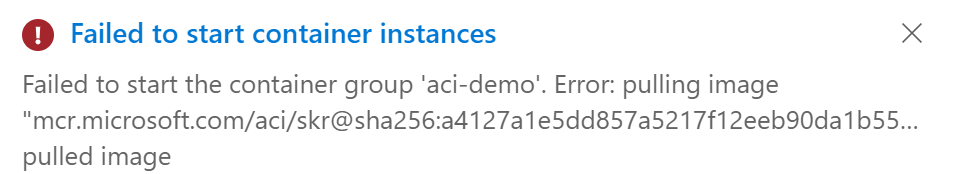

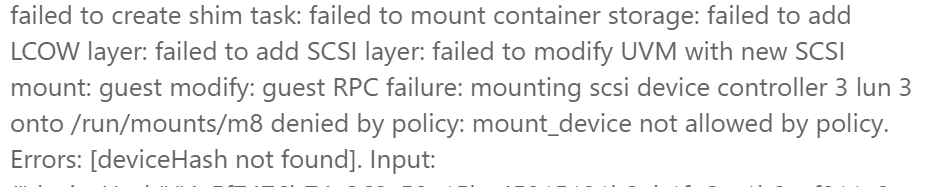

#### The image has been changed in step 4, it does not match the security policy anymore, the deployment is denied by the security policy

### Step 6 : Deploy updated image with the updated security policy 
We want to fix our deployment by generating a new security policy to reflect the updated image, then uploading the ARM Template with the new policy.

In [10]:
# generate new security policy and have it injected into the ARM template 
subprocess.run("az confcom acipolicygen -a ./product/template.json", shell=True, stdout=subprocess.PIPE)

CompletedProcess(args='az confcom acipolicygen -a ./product/template.json', returncode=0, stdout=b'1c3d59f1a1aaa04338345e4c46b27f56338f0539879d137b767448336f8b3b7d\r\n')

In [11]:

# deploy product + skr container with ARM Template from CLI
subprocess.run('az deployment group create -g democcren -f ./product/template.json', shell=True, capture_output=True)

# get the hash of the security policy
with open("./product/template.json", "r") as f:
    # open the template and grab the cce policy
    template = json.loads(f.read())
    security_policy = template.get('resources')[0]['properties']['confidentialComputeProperties']['ccePolicy']
    # decode the base64 encoded policy and hash it
    sha256_hash = sha256(base64.b64decode(security_policy)).hexdigest()
    # print the hash
    print("hash of security policy: ", sha256_hash)


hash of security policy:  1c3d59f1a1aaa04338345e4c46b27f56338f0539879d137b767448336f8b3b7d


### Step 6 : Check deployment is successful and get attestation token 
In this step the security policy hash as part of the attestation token will not match the one generated by the tooling in step 1 as the image has changed. 

In [14]:
# Call the attestation endpoint and pretty print the parsed jwt token from MAA
import requests
import jwt
import json
# TODO: update the public_ip_address

public_ip_address = '20.105.19.191'
runtime_data = 'eyJrZXlzIjpbeyJlIjoiQVFBQiIsImtleV9vcHMiOlsiZW5jcnlwdCJdLCJraWQiOiJOdmhmdXEyY0NJT0FCOFhSNFhpOVByME5QXzlDZU16V1FHdFdfSEFMel93Iiwia3R5IjoiUlNBIiwibiI6InY5NjVTUm15cDh6Ykc1ZU5GdURDbW1pU2VhSHB1akcyYkNfa2VMU3V6dkRNTE8xV3lyVUp2ZWFhNWJ6TW9PMHBBNDZwWGttYnFIaXNvelZ6cGlORExDbzZkM3o0VHJHTWVGUGYyQVBJTXUtUlNyek41NnF2SFZ5SXI1Y2FXZkhXay1GTVJEd0FlZnlOWVJIa2RZWWtnbUZLNDRoaFVkdGxDQUtFdjVVUXBGWmp2aDRpSTlqVkJkR1lNeUJhS1FMaGpJNVdJaC1RRzZaYTVzU3VPQ0ZNbm11eXV2TjVEZmxwTEZ6NTk1U3MtRW9CSVktTmlsNmxDdHZjR2dSLUlialVZSEFPczVhamFtVHpnZU84a3gzVkNFOUhjeUtteVVac2l5aUY2SURScDJCcHkzTkhUakl6N3Rta3BUSHg3dEhuUnRsZkUyRlV2MEI2aV9RWWxfWkE1USJ9XX0='
maa_endpoint = 'sharedeus2.eus2.test.attest.azure.net'

# call the maa endpoint
maa_response = requests.post(f'http://{public_ip_address}/attest/maa', 
                            json={"runtime_data": runtime_data, "maa_endpoint": maa_endpoint})

token = json.loads(maa_response.json().get("result")).get("token")
decoded_token = jwt.decode(token, options={"verify_signature": False}, algorithms=['RS256'])
print("SEV-SNP Host Data:\n", decoded_token.get("x-ms-sevsnpvm-hostdata"))
if(sha256_hash_sum == decoded_token.get("x-ms-sevsnpvm-hostdata")):
    print("Security Policy Hash Matches")
    print("Host is Trusted")
else:
    print("Security Policy Hash Does Not Match")
    print("Host is Untrusted")

SEV-SNP Host Data:
 1c3d59f1a1aaa04338345e4c46b27f56338f0539879d137b767448336f8b3b7d
Security Policy Hash Does Not Match
Host is Untrusted
